## Spam SMS Detection Using TF-IDF Feature Extraction

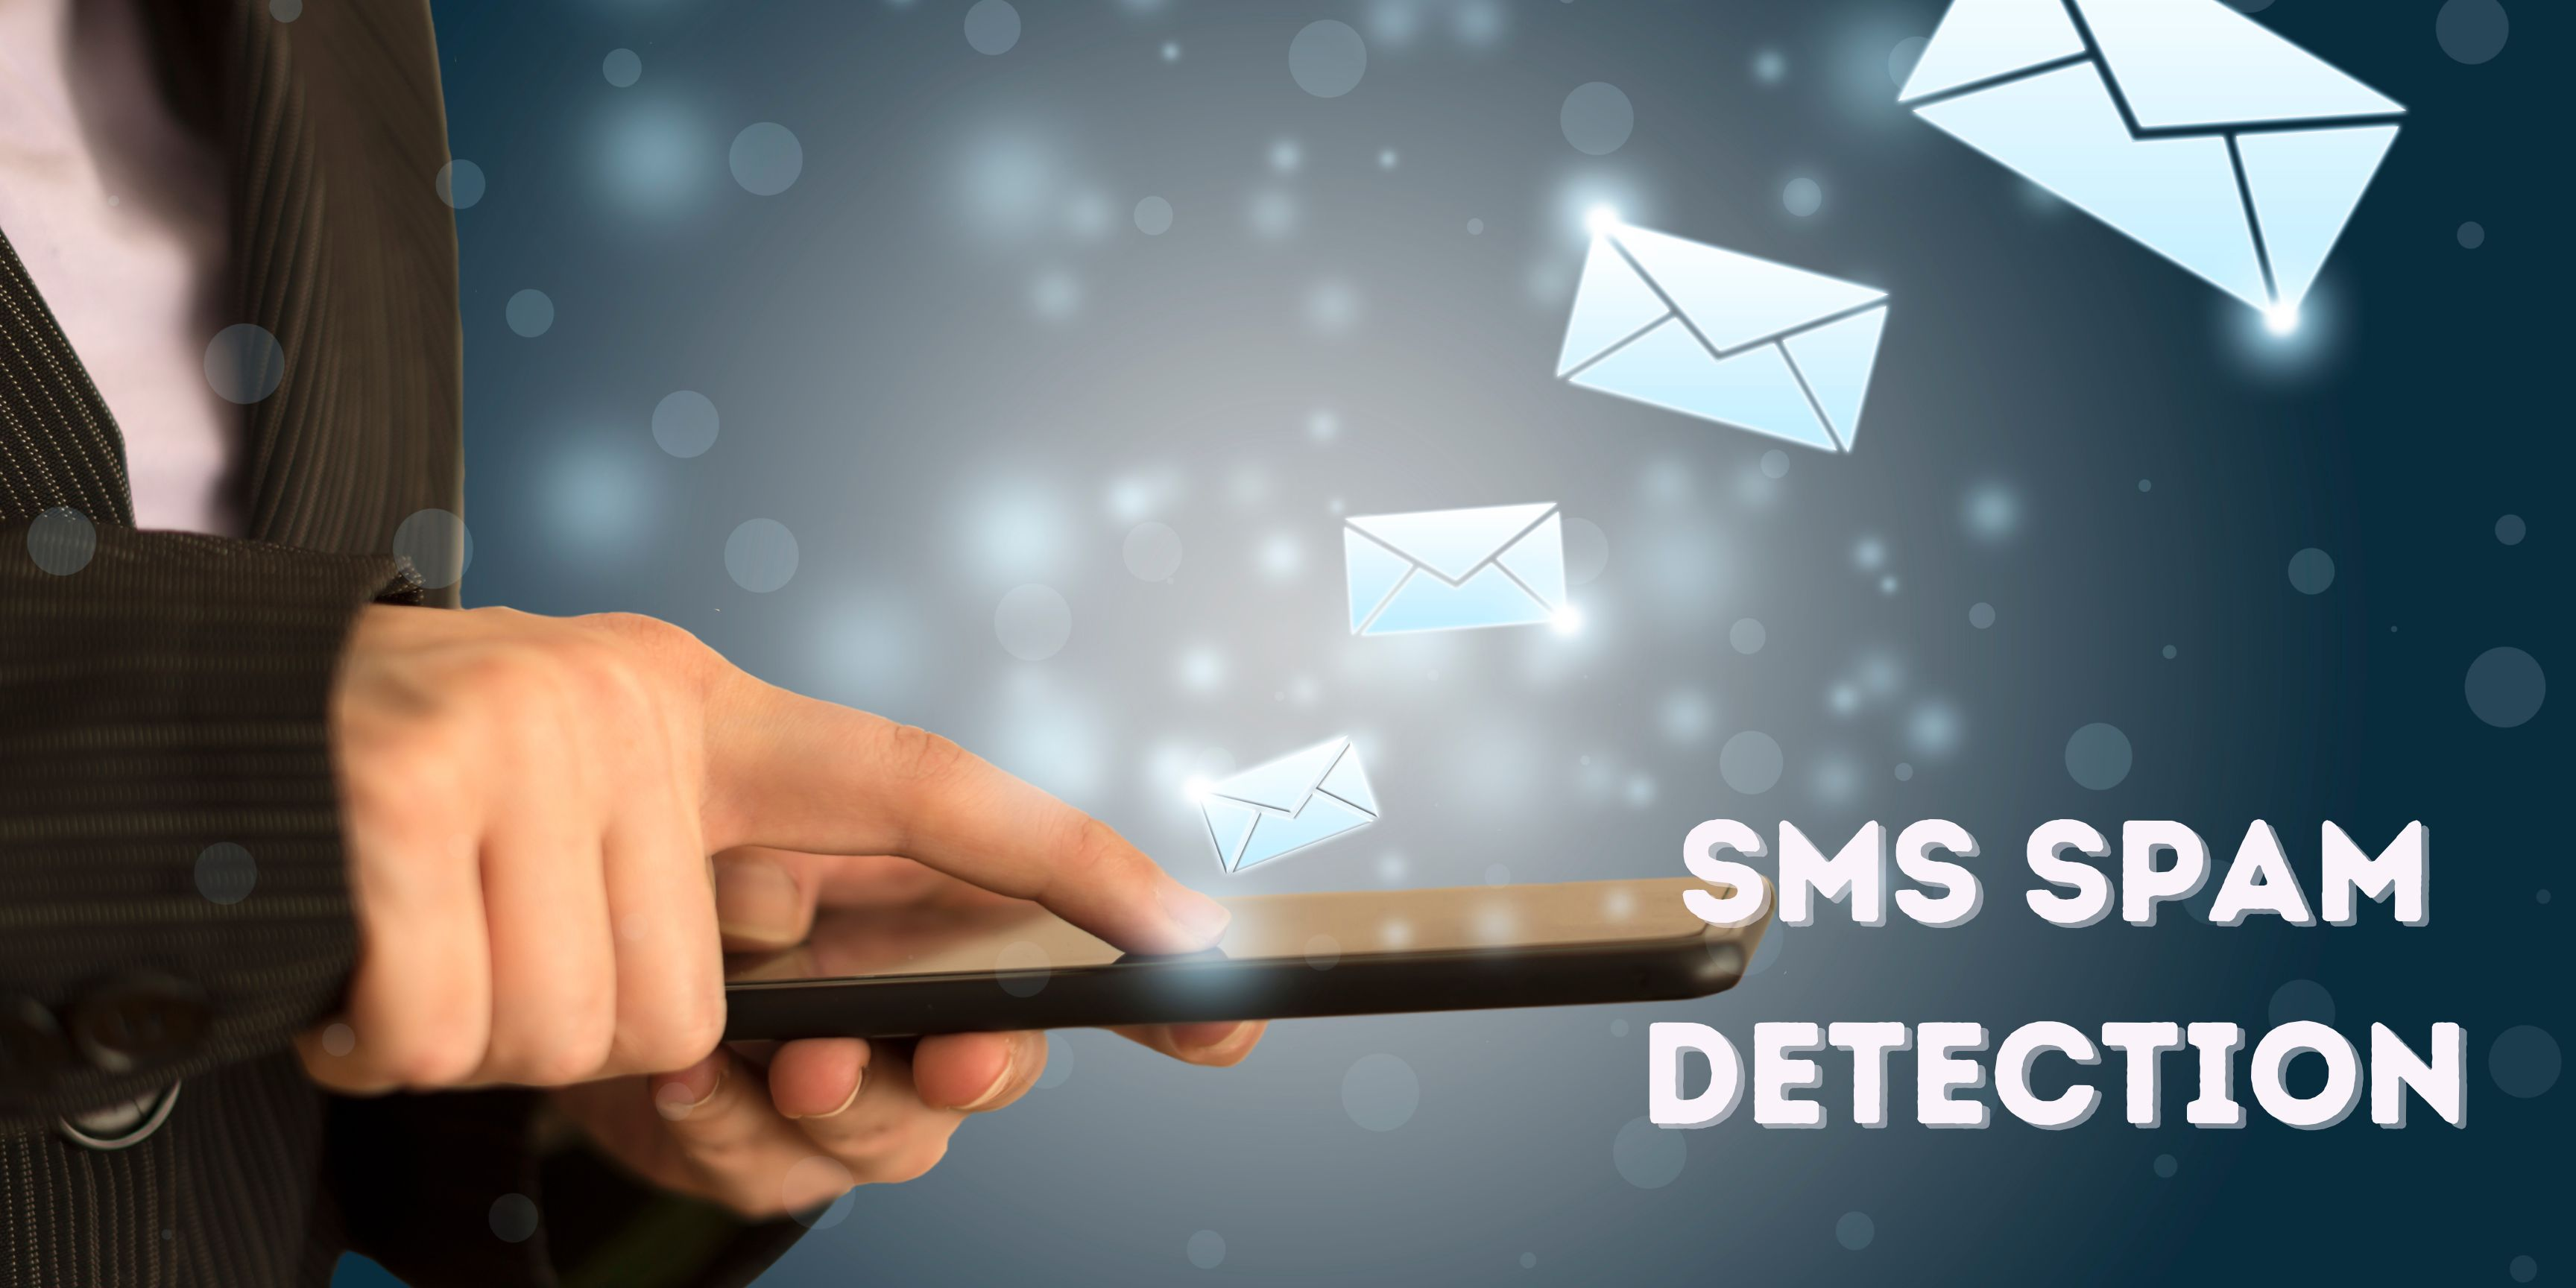

### Source of Dataset

Kaggle: https://www.kaggle.com/datasets/thedevastator/sms-spam-collection-a-more-diverse-dataset

### Background

This analysis utilizes the SMS Spam Collection dataset from Kaggle, which contains a set of SMS messages labeled as either spam or ham (non-spam). To prepare the text data for analysis, it was normalized through a series of preprocessing steps including the removal of stopwords and punctuation, as well as lemmatization. Following normalization, features were extracted using the Term Frequency-Inverse Document Frequency (TF-IDF) method, which transforms the text data into numerical vectors that reflect the importance of each term in the context of the entire dataset. Finally, a spam detection model was developed using the Naive Bayes algorithm, leveraging the TF-IDF features to classify SMS messages as spam or ham.

### Import Essential Libraries

In [1]:
# import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Load the Dataset

In [2]:
# load the datset
data = pd.read_csv('../data/sms_spam.csv')

# check the dimension of the dataset
numrow, numcol = data.shape
print('The dataset contains {} rows and {} columns.'.format(numrow, numcol))

# check the attributes in the dataset
attributes = data.columns
print('Attributes in the dataset:', attributes)

# view the first 5 rows of the dataset
display(data.head(n=5))

The dataset contains 5574 rows and 2 columns.
Attributes in the dataset: Index(['sms', 'label'], dtype='object')


,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [3]:
# summary of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sms     5574 non-null   object
 1   label   5574 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [4]:
# check for duplicates and missing value in the dataset
print('Number of duplicates record in the dataset:', data.duplicated().sum())
print('Number of missing value in each attribute:')
print(data.isna().sum())

Number of duplicates record in the dataset: 403
Number of missing value in each attribute:
sms      0
label    0
dtype: int64


### Disribution of the Labels

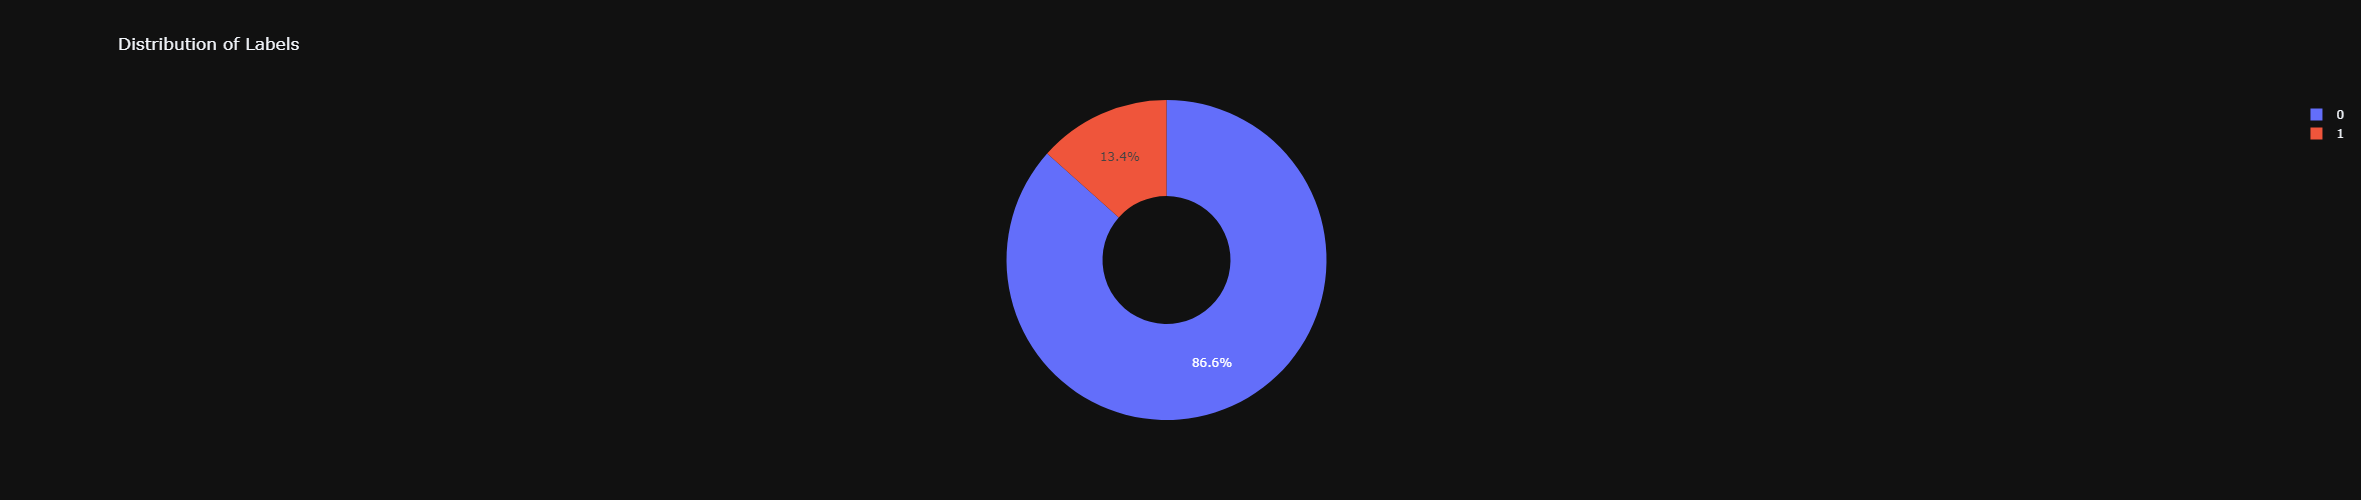

In [30]:
# distribution of label
label = data['label'].value_counts().sort_index()
label_df = pd.DataFrame(label).reset_index()
label_df.columns = ['Label', 'Count']

fig = px.pie(label_df, 
             names='Label', values='Count', 
             width=500, height=500, 
             hole = 0.4,
             template='plotly_dark', 
             title='Distribution of Labels')

fig.show()

In [20]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
import re

pattern = r'[^\w\s]' #  matches any character that is not a word character (\w) or whitespace (\s)

stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def text_normalization(text):
    cleaned_text = re.sub(pattern, '', text)                                   # remove punctuation
    lemmatized_text = lemmatizer.lemmatize(cleaned_text)                       # lemmatization
    tokens = word_tokenize(lemmatized_text)                                    # tokenization
    fil_tokens = [token for token in tokens if token.lower() not in stopwords] # remove stopwords
    processed_text = ' '.join(fil_tokens)
    return processed_text

In [23]:
# insert a new column for normalized text
data['normalized_text'] = data['sms'].apply(lambda x: text_normalization(x))

In [35]:
# define a function to count the number of tokens in the normalized text
def token_count(text):
    tokens = word_tokenize(text)
    return len(tokens)

In [36]:
# insert a new column to count the number of tokens in the normalized text
data['token_count'] = data['normalized_text'].apply(lambda x: token_count(x))

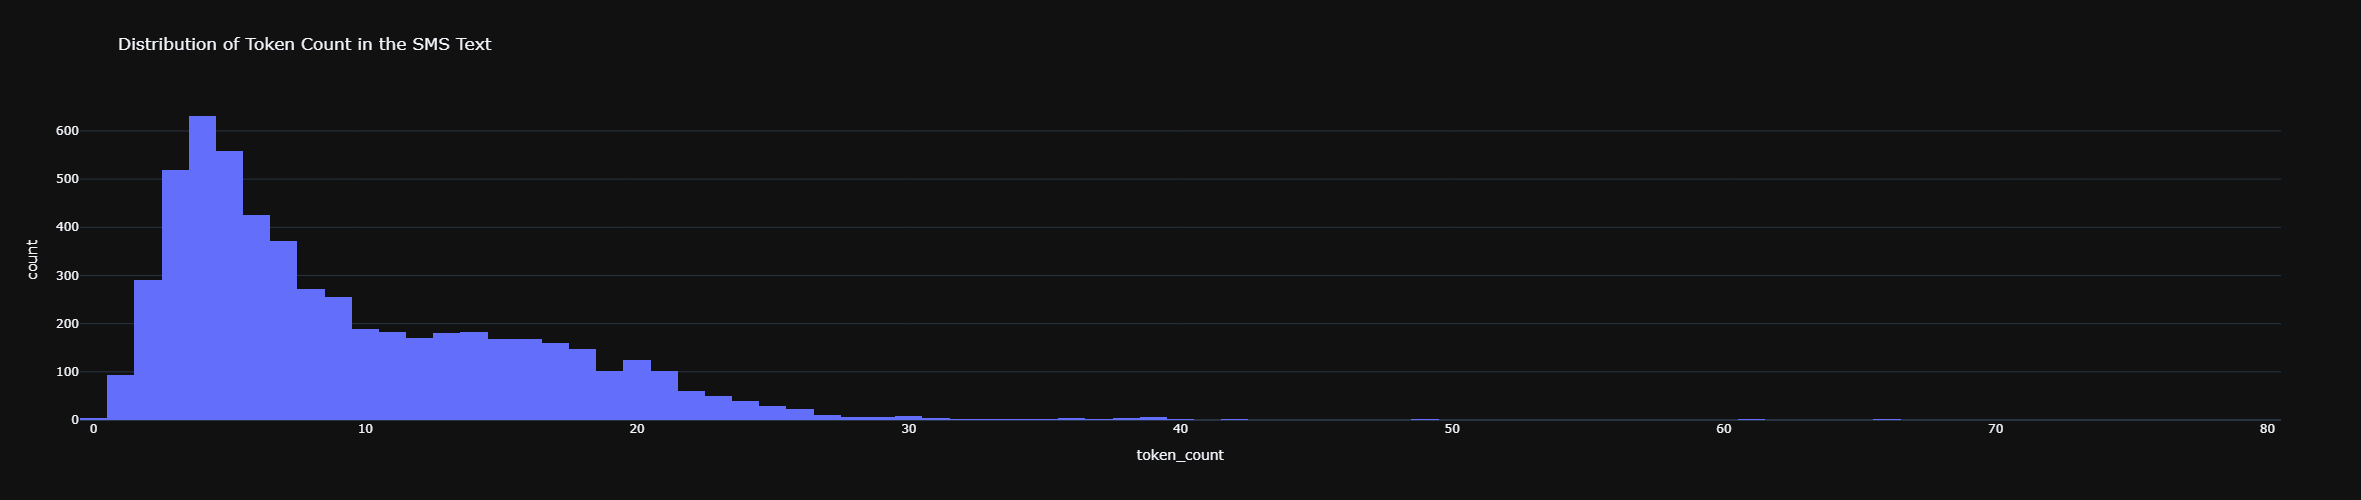

In [43]:
# check the distribution of tokens 
# limitation of the token number for embedding model

fig = px.histogram(data, 
                   x='token_count', 
                   width=800, height=500, 
                   template='plotly_dark', 
                   title='Distribution of Token Count in the SMS Text')

fig.show()

### Data Splitting

In [44]:
# split the dataset into train and test set
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, stratify=data['label'], shuffle=True, random_state=122)

# check the dimension of the train and test dataset
print('Dimension of train dataset:', train.shape)
print('Dimension of test dataset:', test.shape)

Dimension of train dataset: (4459, 4)
Dimension of test dataset: (1115, 4)


In [57]:
# segregate the train and test dataset into feature matrix and target vector
Xtrain = train['normalized_text']
ytrain = train['label']

Xtest = test['normalized_text']
ytest = test['label']

### Feature Extraction

In [58]:
# text feature extraction --- vectorizartion
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

Xtrain_vector = tfidf.fit_transform(Xtrain)
Xtest_vector = tfidf.transform(Xtest)

### Model Training

In [68]:
# train a predictive model using Naive Bayes algorithm
from sklearn.naive_bayes import ComplementNB

cNB = ComplementNB()
cNB.fit(Xtrain_vector, ytrain)

ComplementNB()

### Model Evaluation

In [103]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix

def model_performance(X, y, model):
    ypred = model.predict(X)
    
    accuracy = round(accuracy_score(y, ypred), 3)
    precision = round(precision_score(y, ypred), 3)
    recall = round(recall_score(y, ypred), 3)
    f1 = round(f1_score(y, ypred), 3)
    AUC = round(roc_auc_score(y, ypred), 3)
    
    print('Key Peformance Metrics:\n')
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)
    print('AUC:', AUC)

    print('\n')
    cm = confusion_matrix(y, ypred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt='.5g', cmap='BuPu', cbar=False, xticklabels=['No Spam', 'Spam'], yticklabels=['No Spam', 'Spam'])
    plt.title('Confusion Matrix')
    plt.show()

Key Peformance Metrics:

Accuracy: 0.98
Precision: 0.887
Recall: 0.98
F1 Score: 0.931
AUC: 0.98




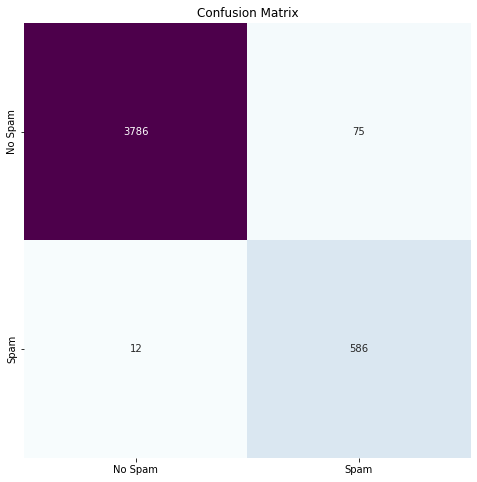

In [104]:
# evaluate the model performance on test dataset
model_performance(Xtrain_vector, ytrain, cNB)

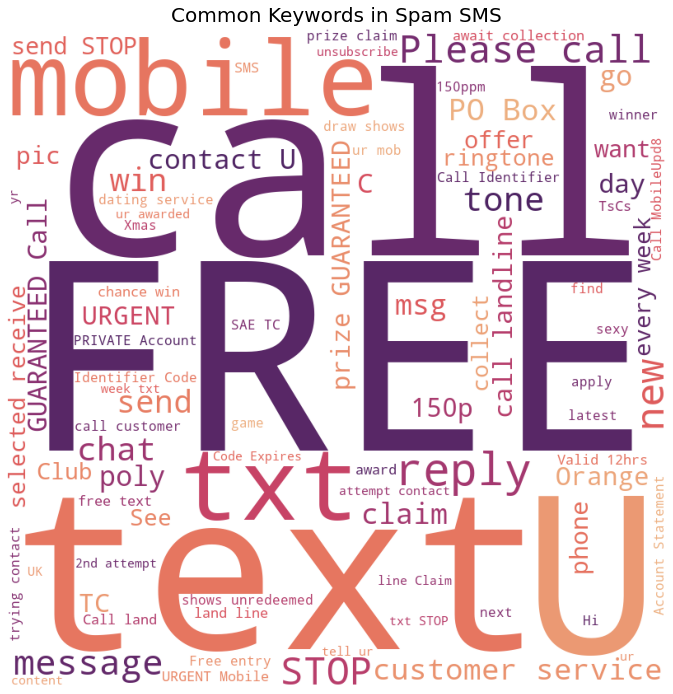

In [107]:
# what are the common keywords used in spam SMS
from wordcloud import WordCloud

spam = data[data['label']==1]
spam_text = ' '.join(spam['normalized_text'])


# create a word cloud using the combined text
wordcloud_spam = WordCloud(width = 800, height = 800,
                            background_color ='white',
                            colormap = 'flare',
                            min_font_size = 15).generate(spam_text)

# plot the WordCloud image
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_spam)
plt.axis('off')
plt.title('Common Keywords in Spam SMS', fontsize=20)
plt.tight_layout(pad=2)
plt.show()

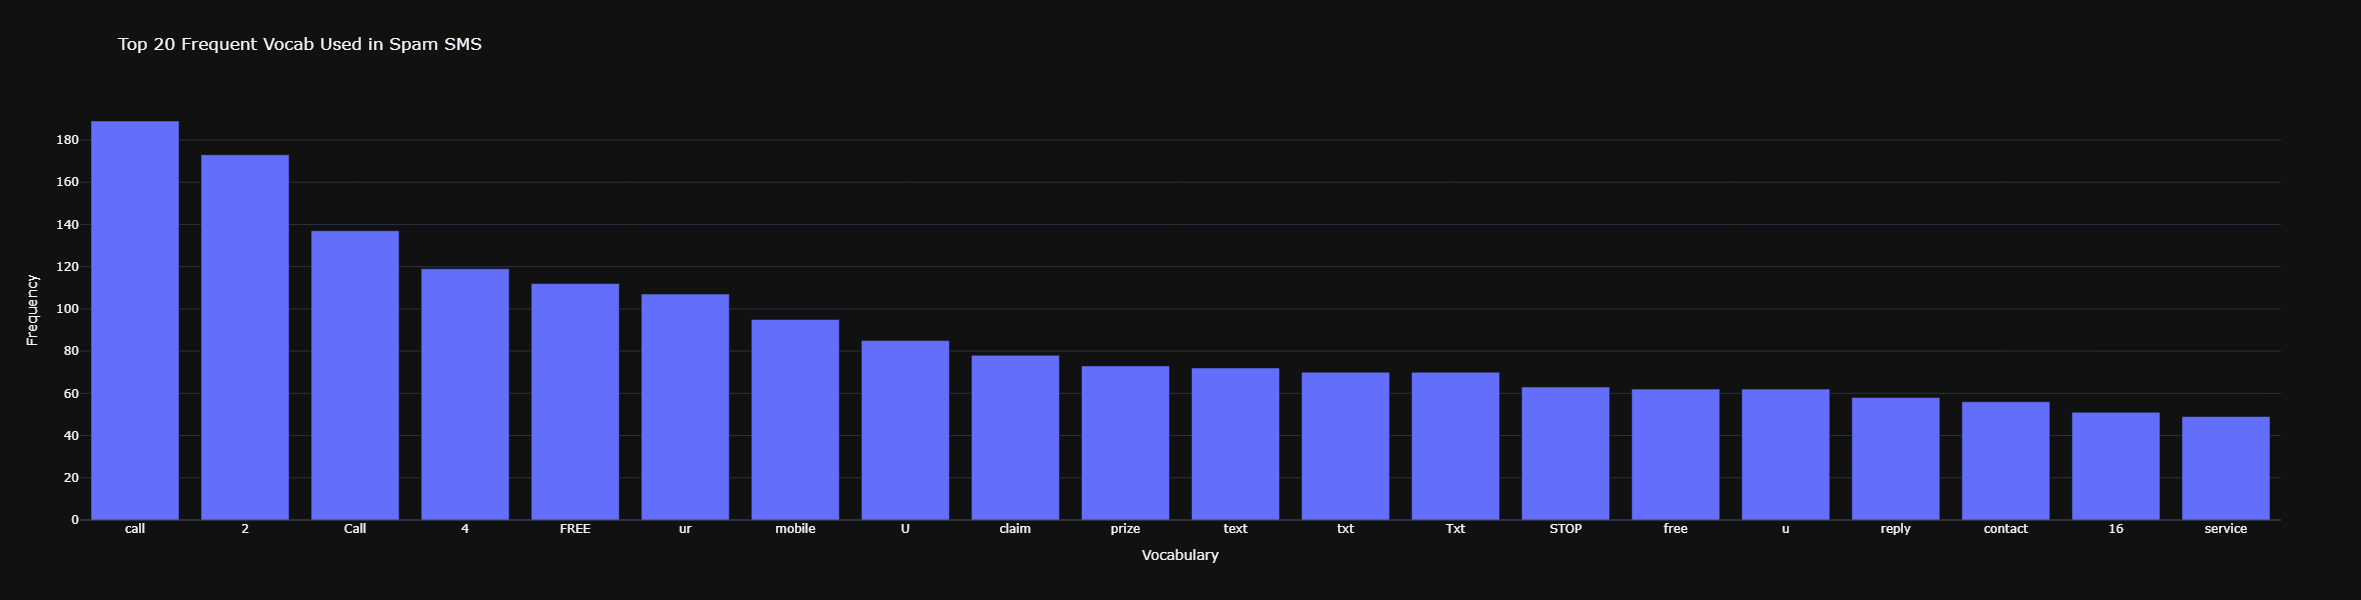

In [123]:
# count the frequency of the vocabulary in spam text
from collections import Counter

spam_vocab_count = Counter(word_tokenize(spam_text))
spam_most_common = spam_vocab_count.most_common()
spam_freq = pd.DataFrame(spam_most_common[:20], columns=['Vocab','Frequency'])

fig = px.bar(spam_freq, 
             x='Vocab', y='Frequency', 
             width=900, height=600, 
             template='plotly_dark', 
             title='Top 20 Frequent Vocab Used in Spam SMS')

fig.update_layout(
    xaxis = dict(
        title = 'Vocabulary'
    ),
    yaxis = dict(
        title = 'Frequency'
    )
)

fig.show()